In [1]:
# Set whether this notebook is run in colab or not
colab = True

# Prepare folder (to run just the first time)

In [2]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


# Initialization

In [3]:
from tensorflow.python.client import device_lib

import random
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Settings for reproducibility
random_seed = 44
tf.random.set_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
#os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.keras.utils.set_random_seed(random_seed)


def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]


print('Available devices:', get_available_devices())

#tf.debugging.set_log_device_placement(True)

Available devices: ['/device:CPU:0', '/device:GPU:0']


In [4]:
# Set mixed precision
# https://www.tensorflow.org/guide/mixed_precision
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


In [5]:
# Path to the working directory
if colab:
    #%cd -0
    #%cd "/content/drive/MyDrive/green_areas_detection"
    #%cp -R "/content/drive/MyDrive/green_areas_detection/dataset" "./"
    base_dir = '/content/drive/MyDrive/green_areas_detection'
    %cp -R "/content/drive/MyDrive/green_areas_detection/green_areas_detection/models" "./"
    %cp -R "/content/drive/MyDrive/green_areas_detection/green_areas_detection/utils" "./"
    %cp -R "/content/drive/MyDrive/green_areas_detection/green_areas_detection/weights" "./"
else:
    base_dir = ''

In [ ]:
# TRANSFORMING SHP FILES INTO BINARY IMAGES (i.e. masks)

from utils.PyMask import shpToMask
import os 

dataset_folder = 'dataset'
samples_names = os.listdir(dataset_folder)

valid_samples_names = ['19K59', '19K35', '19K38', '18K11', '19K53']

for sample_name in samples_names:
    if sample_name in valid_samples_names:
        sample_folder_path = os.path.join(dataset_folder, sample_name) 
        #print(sample_folder_path)
        img_path = os.path.join(sample_folder_path, f'{sample_name}.tif')
        #print(img_path)
        shp_path = os.path.join(sample_folder_path, 'green_areas_shp', f'{sample_name}_greenareas.shp')
        #print(shp_path)
        shpToMask(img_path, shp_path)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (98211778 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


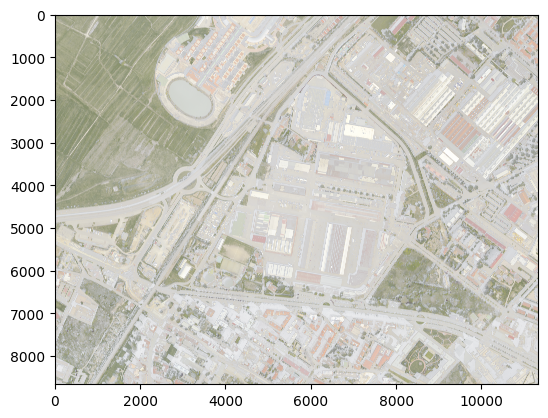

In [6]:
# Visualize one image
img = Image.open(os.path.join(base_dir, 'dataset', '19K35', '19K35.tif'))
img = np.array(img)[:, :, :3]
plt.imshow(img)

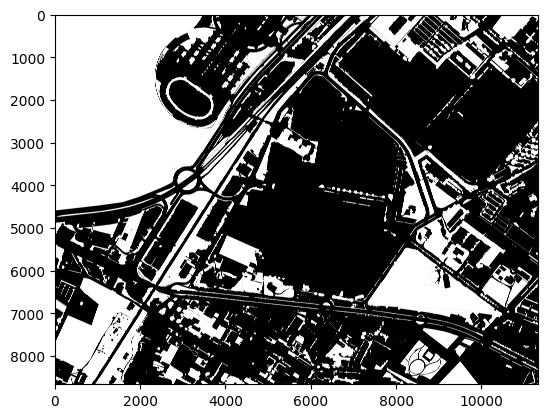

In [7]:

# Visualize one mask
mask = Image.open(os.path.join(base_dir, 'dataset', '19K35', '19K35_mask.png'))
mask = np.array(mask)
plt.imshow(mask)

# Prepare dataset

### Load dataset

We use $4$ images for the training : `19K35`, `19K38`, `19K53`, `18K11`.

We use $1$ image for the validation : `19K59`.  

We use only the RGB channels.

In [8]:
from utils.dataset_handler import load_images_masks

dataset_folder = os.path.join(base_dir, 'dataset')
#samples_names = os.listdir(dataset_folder)

#valid_samples_names = ['19K35', '19K38']
train_samples_names = ['19K35', '19K38', '19K53', '18K11']
val_samples_names = ['19K59']
test_samples_names = []

train_images, train_masks = load_images_masks(dataset_folder, train_samples_names, infrared=False)
print('Train shapes:', train_images.shape, train_masks.shape)

val_images, val_masks = load_images_masks(dataset_folder, val_samples_names, infrared=False)
print('Val shapes:', val_images.shape, val_masks.shape)

test_images, test_masks = load_images_masks(dataset_folder, test_samples_names, infrared=False)
print('Test shapes:', test_images.shape, test_masks.shape)

Train shapes: (4, 8666, 11333, 3) (4, 8666, 11333, 1)
Val shapes: (1, 8666, 11333, 3) (1, 8666, 11333, 1)
Test shapes: (0,) (0,)


### Crop dataset

In [9]:
from utils.dataset_handler import crop_images_masks

crop_size = 1024
step = 512

train_cropped_images, train_cropped_masks = crop_images_masks(train_images, train_masks, crop_size, step)
print('Train shapes:', train_cropped_images.shape, train_cropped_masks.shape)

val_cropped_images, val_cropped_masks = crop_images_masks(val_images, val_masks, crop_size, step)
print('Val shapes:', val_cropped_images.shape, val_cropped_masks.shape)

#test_cropped_images, test_cropped_masks = crop(test_images, test_masks, crop_size, step)
#print('Test shapes:', test_cropped_images.shape, test_cropped_masks.shape)

Train shapes: (1408, 1024, 1024, 3) (1408, 1024, 1024, 1)
Val shapes: (352, 1024, 1024, 3) (352, 1024, 1024, 1)


<Figure size 640x480 with 0 Axes>

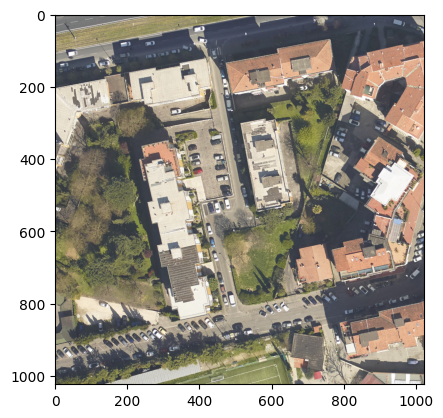

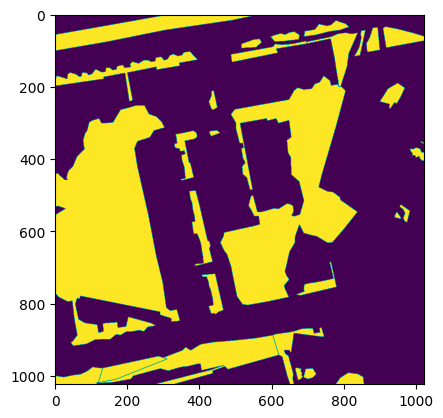

<Figure size 640x480 with 0 Axes>

In [10]:
# Visualize one crop image and mask
index = 36
plt.imshow(val_cropped_images[index, :, :])
plt.figure()
#plt.imshow(infrared[index, :, :])
#plt.figure()
plt.imshow(val_cropped_masks[index, :, :])
plt.figure()

### Normalizing the input: NO

In [11]:
# Normalizing input images
# NO: much more RAM memory recquired. Over 60GB RAM.
# We keep integer values: no worse results

#images_dataset = images_dataset.astype(np.float16)/255
#images_dataset.min(), images_dataset.max()

# Unet

In [10]:
from models.green_areas_detection_models import build_unet
unet = build_unet(input_shape=(crop_size,crop_size,3))

In [11]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1024, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 32)         0         ['batch_normalization[0][0

### Train

In [12]:
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from models.callbacks import DisplayCallback

reduce_lr_callback = ReduceLROnPlateau(monitor='loss', patience=3, min_delta=0.01)

callback_checkpoint = ModelCheckpoint('UNET.{epoch:02d}-{val_binary_accuracy:.4f}.hdf5', save_weights_only=True,
                                      save_best_only=True, monitor='val_binary_accuracy')

"""earlystopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)"""

# Visualize evolution of the predictions on the 37th validation crop during training
index = 36
display_callback = DisplayCallback(val_cropped_images[index, :, :], val_cropped_masks[index, :, :], 5)

callbacks = [reduce_lr_callback, callback_checkpoint, display_callback] #, earlystopping_callback]

Epoch 1/30
1/1 [==============================] - 1s 983ms/step


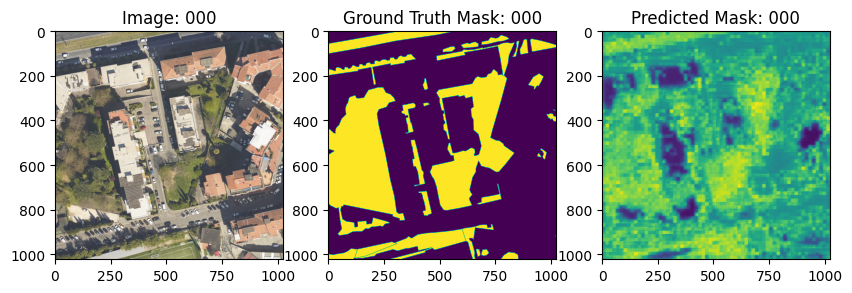

352/352 [==============================] - 71s 150ms/step - loss: 0.3426 - binary_accuracy: 0.8829 - val_loss: 0.5997 - val_binary_accuracy: 0.6214 - lr: 0.0010
Epoch 2/30
352/352 [==============================] - 48s 136ms/step - loss: 0.1875 - binary_accuracy: 0.9300 - val_loss: 0.2655 - val_binary_accuracy: 0.8962 - lr: 0.0010
Epoch 3/30
352/352 [==============================] - 48s 135ms/step - loss: 0.1541 - binary_accuracy: 0.9413 - val_loss: 0.2086 - val_binary_accuracy: 0.9171 - lr: 0.0010
Epoch 4/30
352/352 [==============================] - 48s 135ms/step - loss: 0.1469 - binary_accuracy: 0.9448 - val_loss: 0.1988 - val_binary_accuracy: 0.9224 - lr: 0.0010
Epoch 5/30
352/352 [==============================] - 48s 135ms/step - loss: 0.1330 - binary_accuracy: 0.9496 - val_loss: 0.1924 - val_binary_accuracy: 0.9238 - lr: 0.0010
Epoch 6/30
1/1 [==============================] - 0s 23ms/step


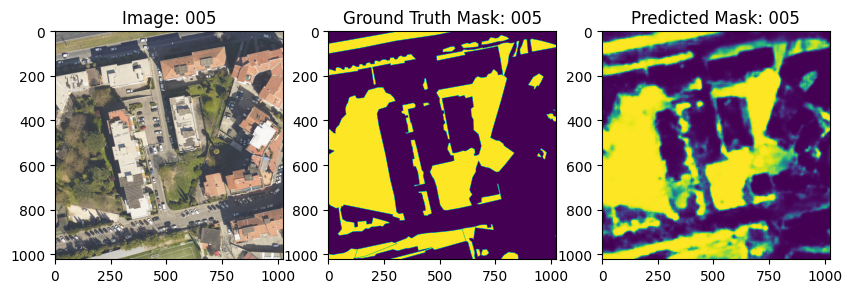

352/352 [==============================] - 48s 137ms/step - loss: 0.1279 - binary_accuracy: 0.9520 - val_loss: 0.1988 - val_binary_accuracy: 0.9206 - lr: 0.0010
Epoch 7/30
352/352 [==============================] - 48s 135ms/step - loss: 0.1283 - binary_accuracy: 0.9520 - val_loss: 0.1525 - val_binary_accuracy: 0.9385 - lr: 0.0010
Epoch 8/30
352/352 [==============================] - 48s 135ms/step - loss: 0.1134 - binary_accuracy: 0.9572 - val_loss: 0.1973 - val_binary_accuracy: 0.9180 - lr: 0.0010
Epoch 9/30
352/352 [==============================] - 48s 135ms/step - loss: 0.1231 - binary_accuracy: 0.9539 - val_loss: 1.1247 - val_binary_accuracy: 0.8619 - lr: 0.0010
Epoch 10/30
352/352 [==============================] - 48s 135ms/step - loss: 0.1132 - binary_accuracy: 0.9575 - val_loss: 0.1482 - val_binary_accuracy: 0.9412 - lr: 0.0010
Epoch 11/30
1/1 [==============================] - 0s 24ms/step


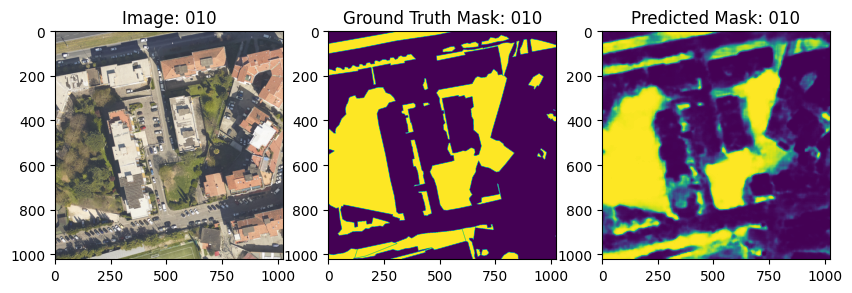

352/352 [==============================] - 48s 138ms/step - loss: 0.1066 - binary_accuracy: 0.9599 - val_loss: 0.1528 - val_binary_accuracy: 0.9392 - lr: 0.0010
Epoch 12/30
352/352 [==============================] - 48s 135ms/step - loss: 0.0910 - binary_accuracy: 0.9648 - val_loss: 0.1335 - val_binary_accuracy: 0.9472 - lr: 1.0000e-04
Epoch 13/30
352/352 [==============================] - 48s 135ms/step - loss: 0.0866 - binary_accuracy: 0.9666 - val_loss: 0.1405 - val_binary_accuracy: 0.9454 - lr: 1.0000e-04
Epoch 14/30
352/352 [==============================] - 48s 136ms/step - loss: 0.0846 - binary_accuracy: 0.9674 - val_loss: 0.1327 - val_binary_accuracy: 0.9477 - lr: 1.0000e-04
Epoch 15/30
352/352 [==============================] - 48s 136ms/step - loss: 0.0822 - binary_accuracy: 0.9681 - val_loss: 0.1326 - val_binary_accuracy: 0.9484 - lr: 1.0000e-04
Epoch 16/30
1/1 [==============================] - 0s 24ms/step


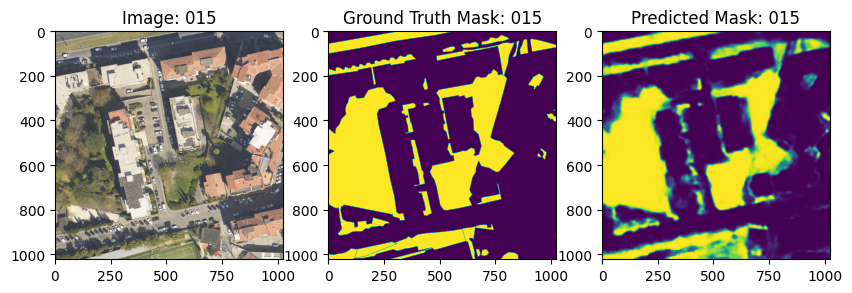

352/352 [==============================] - 49s 138ms/step - loss: 0.0802 - binary_accuracy: 0.9688 - val_loss: 0.1335 - val_binary_accuracy: 0.9481 - lr: 1.0000e-05
Epoch 17/30
352/352 [==============================] - 48s 135ms/step - loss: 0.0798 - binary_accuracy: 0.9689 - val_loss: 0.1343 - val_binary_accuracy: 0.9481 - lr: 1.0000e-05
Epoch 18/30
352/352 [==============================] - 48s 135ms/step - loss: 0.0793 - binary_accuracy: 0.9691 - val_loss: 0.1336 - val_binary_accuracy: 0.9481 - lr: 1.0000e-05
Epoch 19/30
352/352 [==============================] - 48s 135ms/step - loss: 0.0796 - binary_accuracy: 0.9689 - val_loss: 0.1333 - val_binary_accuracy: 0.9483 - lr: 1.0000e-05
Epoch 20/30
352/352 [==============================] - 48s 135ms/step - loss: 0.0795 - binary_accuracy: 0.9690 - val_loss: 0.1338 - val_binary_accuracy: 0.9479 - lr: 1.0000e-06
Epoch 21/30
1/1 [==============================] - 0s 22ms/step


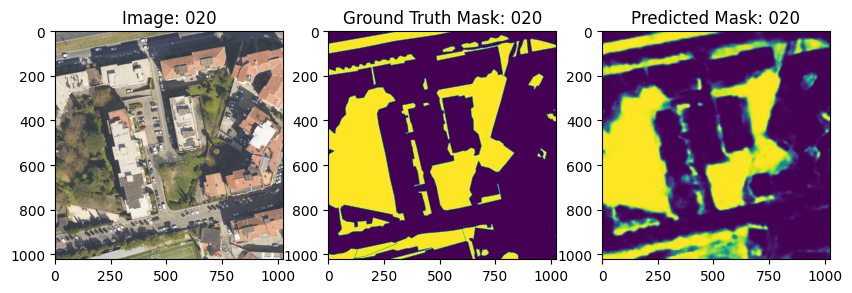

352/352 [==============================] - 48s 138ms/step - loss: 0.0789 - binary_accuracy: 0.9692 - val_loss: 0.1336 - val_binary_accuracy: 0.9480 - lr: 1.0000e-06
Epoch 22/30
352/352 [==============================] - 48s 135ms/step - loss: 0.0786 - binary_accuracy: 0.9694 - val_loss: 0.1339 - val_binary_accuracy: 0.9479 - lr: 1.0000e-06
Epoch 23/30
352/352 [==============================] - 48s 135ms/step - loss: 0.0787 - binary_accuracy: 0.9692 - val_loss: 0.1337 - val_binary_accuracy: 0.9480 - lr: 1.0000e-07
Epoch 24/30
352/352 [==============================] - 48s 135ms/step - loss: 0.0795 - binary_accuracy: 0.9691 - val_loss: 0.1337 - val_binary_accuracy: 0.9480 - lr: 1.0000e-07
Epoch 25/30
352/352 [==============================] - 48s 135ms/step - loss: 0.0790 - binary_accuracy: 0.9691 - val_loss: 0.1341 - val_binary_accuracy: 0.9478 - lr: 1.0000e-07
Epoch 26/30
1/1 [==============================] - 0s 21ms/step


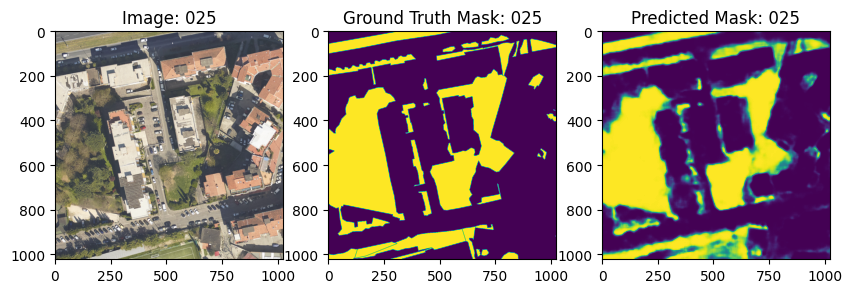

352/352 [==============================] - 48s 137ms/step - loss: 0.0784 - binary_accuracy: 0.9694 - val_loss: 0.1336 - val_binary_accuracy: 0.9480 - lr: 1.0000e-08
Epoch 27/30
352/352 [==============================] - 48s 135ms/step - loss: 0.0787 - binary_accuracy: 0.9693 - val_loss: 0.1340 - val_binary_accuracy: 0.9479 - lr: 1.0000e-08
Epoch 28/30
352/352 [==============================] - 48s 135ms/step - loss: 0.0787 - binary_accuracy: 0.9692 - val_loss: 0.1341 - val_binary_accuracy: 0.9478 - lr: 1.0000e-08
Epoch 29/30
352/352 [==============================] - 48s 135ms/step - loss: 0.0791 - binary_accuracy: 0.9692 - val_loss: 0.1336 - val_binary_accuracy: 0.9479 - lr: 1.0000e-09
Epoch 30/30
352/352 [==============================] - 48s 135ms/step - loss: 0.0786 - binary_accuracy: 0.9694 - val_loss: 0.1338 - val_binary_accuracy: 0.9480 - lr: 1.0000e-09


In [14]:
# System RAM : ~25GB
# GPU RAM : ~15GB
hist = unet.fit(train_cropped_images, train_cropped_masks, batch_size=4,
                epochs=30, callbacks=callbacks,
                validation_data=(val_cropped_images,val_cropped_masks))

Best validation score: $0.9484$, epoch $15$.
Associated training score: $0.9681$.

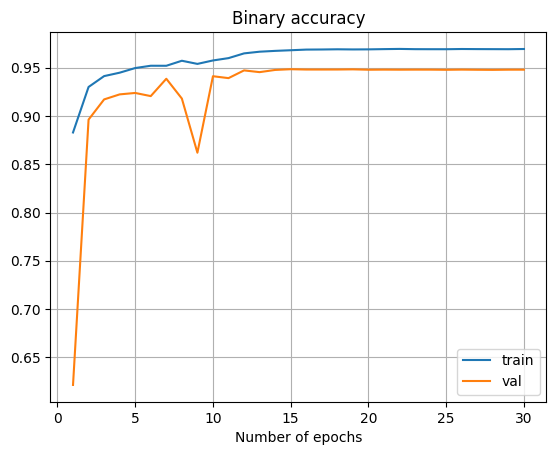

In [15]:
from utils.evaluation import plot_history
plot_history(hist)

### Load best model

In [17]:
unet.load_weights(os.path.join('weights', 'UNET.15-0.9484.hdf5'))

### Visualize the predictions on a validation crop

(1024, 1024, 3)
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

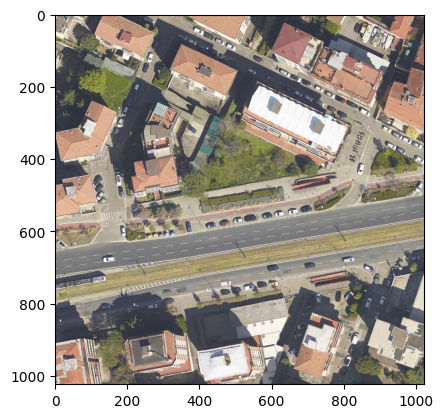

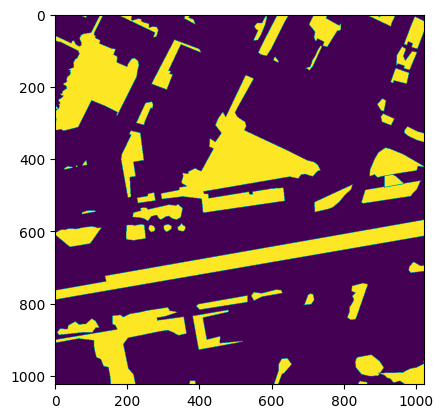

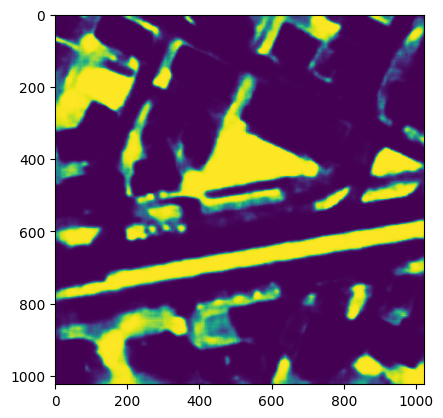

<Figure size 640x480 with 0 Axes>

In [18]:
# Visualize the predicted scores on a validation crop

index = 12
img = val_cropped_images[index, :, :, :]
mask = val_cropped_masks[index, :, :, 0]

plt.imshow(img)
plt.figure()

plt.imshow(mask, vmin=0, vmax=1)
plt.figure()

print(img.shape)
img = np.expand_dims(img, axis=0)
pred = unet.predict(img)
binary_preds = np.argmax(pred, axis=-1).astype('uint8')
binary_preds = binary_preds[0, :]
#binary_mask = Image.fromarray(binary_preds)
#plt.imshow(binary_preds[..., 0])#cmap='gray', vmin=0, vmax=1)
plt.imshow(pred[0, :, :, 0], vmin=0, vmax=1)
plt.figure()

### Validation crops evaluation
Evaluation on the validation crops.

In [19]:
from utils.evaluation import compute_pixelwise_retrieval_metrics

val_cropped_preds = unet.predict(val_cropped_images, batch_size=4)
compute_pixelwise_retrieval_metrics(val_cropped_preds[..., 0], val_cropped_masks[..., 0])

88/88 [==============================] - 3s 34ms/step


{'auroc': 0.9886551804373264,
 'fpr': array([0.        , 0.        , 0.        , ..., 0.99999993, 0.99999996,
        1.        ]),
 'tpr': array([0.00000000e+00, 1.78400664e-07, 4.66586352e-07, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 'optimal_threshold': 0.5004692,
 'optimal_fpr': 0.02470669150352478,
 'optimal_fnr': 0.026865682818672874}

Auroc: $0.989$. Optimal threshold: $0.5$.

### Validation full image evaluation
Evaluation on the full validation image. First on the binary predictions, and then on the polylines mask.


**1) Binary predictions**

In [ ]:
from utils.utils import predict_on_img

val_img = val_images[0]
val_mask = val_masks[0]

# Predictions on the full validation image.
# (Basically, aggregation of the predictions on the crops).
val_preds = predict_on_img(unet, val_img, step=step, batch_size=4,
                           crop_size=crop_size, use_gaussian=False);

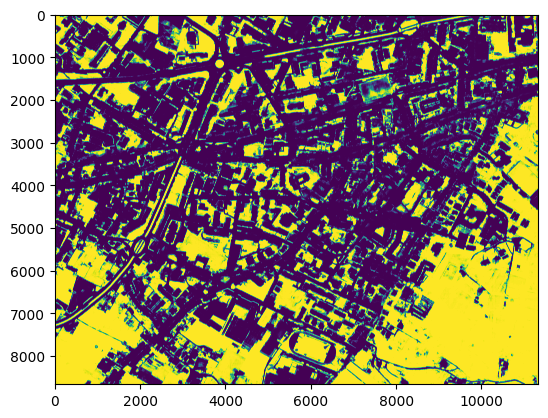

In [21]:
plt.imshow(val_preds)

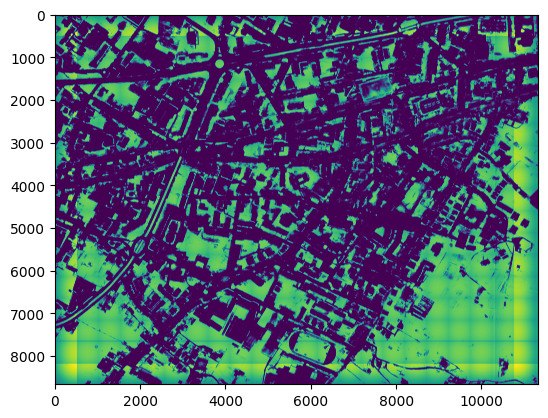

In [ ]:
# TO DELETE
# With gaussian smoothing
plt.imshow(val_preds)

In [22]:
# Compute the binary accuracy
acc = tf.keras.metrics.BinaryAccuracy()
acc.update_state(val_mask, val_preds)
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.94901437>

Binary accuracy: $0.949$.

In [ ]:
compute_pixelwise_retrieval_metrics(val_preds[..., 0], val_mask[..., 0])

{'auroc': 0.9864117044304802,
 'fpr': array([0.00000000e+00, 4.94843207e-05, 1.39291081e-04, ...,
        9.99838405e-01, 9.99982963e-01, 1.00000000e+00]),
 'tpr': array([0.        , 0.12006676, 0.26847538, ..., 1.        , 1.        ,
        1.        ]),
 'optimal_threshold': 0.482,
 'optimal_fpr': 0.0270581396052111,
 'optimal_fnr': 0.029616631113225544}

Auroc: $0.9864$. Best threshold: $0.482$.

**2) Polylines mask**

In [ ]:
from PIL import ImageDraw
from utils.utils import get_polylines

# Thresholded binary predictions: either 0 or 1
threshold = 0.5
binary_preds = (val_preds>threshold).astype('uint8')

# Compute the poly-lines
tolerance = 1.
min_area = 10
poly_lines = get_polylines(binary_preds, tolerance=tolerance, min_area=min_area)

# Compute the polylines mask
polyline_mask = np.zeros(shape=binary_preds.shape[:2], dtype=np.uint8)
polyline_mask = Image.fromarray(polyline_mask)
draw_polyline = ImageDraw.Draw(polyline_mask)
for p in poly_lines:
    draw_polyline.polygon(p, fill=1)
#polyline_mask.putpalette(get_palette())
#polyline_mask.save(join(out_folder, f"{img_basename}_polylines.png"))
polyline_mask = np.array(polyline_mask)

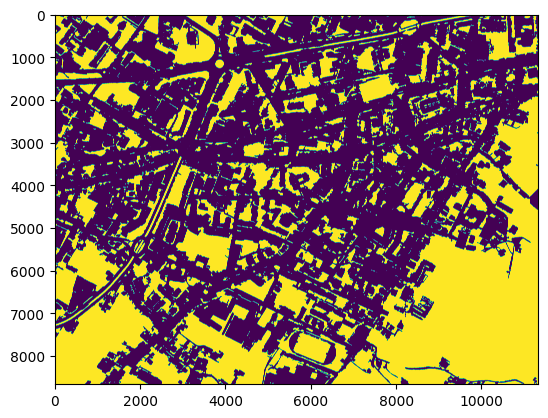

In [ ]:
plt.imshow(polyline_mask)

In [ ]:
# Compute the binary accuracy
acc = tf.keras.metrics.BinaryAccuracy()
acc.update_state(val_mask, polyline_mask)
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9342656>

Binary accuracy: $0.9342$. Slightly worse than before ...

*The vectorization process makes the mask better looking and more regular. The price to pay is some points of the accuracy...*

In [ ]:
compute_pixelwise_retrieval_metrics(polyline_mask, val_mask[..., 0])

{'auroc': 0.9332151253077138,
 'fpr': array([0.        , 0.06159655, 1.        ]),
 'tpr': array([0.       , 0.9280268, 1.       ]),
 'optimal_threshold': 1,
 'optimal_fpr': 0.037034407421073265,
 'optimal_fnr': 0.02869991825216727}

### Save the polylines mask

In [ ]:
# Save polylines mask
from utils.utils import get_palette
m = Image.fromarray(polyline_mask)
m.putpalette(get_palette())
m.save("polylines.png")

# Attention Unet

In [12]:
from models.green_areas_detection_models import build_attunet
att_unet = build_attunet(input_shape=(crop_size,crop_size,3), n_ch=32, L=3)

In [13]:
att_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1024, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1024, 1024, 32)       896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1024, 1024, 32)       128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 1024, 1024, 32)       0         ['batch_normalization[0][0

In [ ]:
"""from sklearn.model_selection import train_test_split
(images_dataset_train, images_dataset_val,
 masks_dataset_train, masks_dataset_val) =  train_test_split(images_dataset,
                                                             masks_dataset,
                                                             test_size=0.2,
                                                             random_state=random_seed)"""

### Train

In [14]:
att_unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from models.callbacks import DisplayCallback

reduce_lr_callback = ReduceLROnPlateau(monitor='loss', patience=3, min_delta=0.01)

callback_checkpoint = ModelCheckpoint('ATT_UNET.{epoch:02d}-{val_binary_accuracy:.4f}.hdf5', save_weights_only=True,
                                      save_best_only=True, monitor='val_binary_accuracy')

"""earlystopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)"""

# Visualize evolution of the predictions on the 37th validation crop during training
index = 36
display_callback = DisplayCallback(val_cropped_images[index, :, :], val_cropped_masks[index, :, :], 5)

callbacks = [reduce_lr_callback, callback_checkpoint, display_callback] #, earlystopping_callback]

Epoch 1/30
1/1 [==============================] - 3s 3s/step


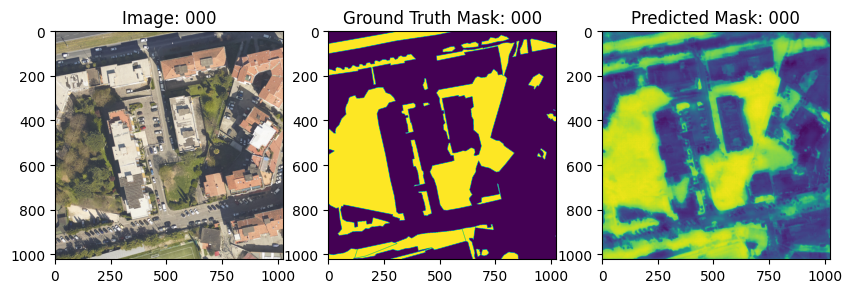

352/352 [==============================] - 204s 347ms/step - loss: 0.3966 - binary_accuracy: 0.8927 - val_loss: 0.3607 - val_binary_accuracy: 0.8908 - lr: 0.0010
Epoch 2/30
352/352 [==============================] - 116s 328ms/step - loss: 0.3301 - binary_accuracy: 0.9296 - val_loss: 0.4131 - val_binary_accuracy: 0.8797 - lr: 0.0010
Epoch 3/30
352/352 [==============================] - 116s 328ms/step - loss: 0.2830 - binary_accuracy: 0.9416 - val_loss: 0.3487 - val_binary_accuracy: 0.8507 - lr: 0.0010
Epoch 4/30
352/352 [==============================] - 116s 329ms/step - loss: 0.2515 - binary_accuracy: 0.9459 - val_loss: 0.2285 - val_binary_accuracy: 0.9339 - lr: 0.0010
Epoch 5/30
352/352 [==============================] - 116s 328ms/step - loss: 0.2303 - binary_accuracy: 0.9488 - val_loss: 0.2786 - val_binary_accuracy: 0.8952 - lr: 0.0010
Epoch 6/30
1/1 [==============================] - 0s 26ms/step


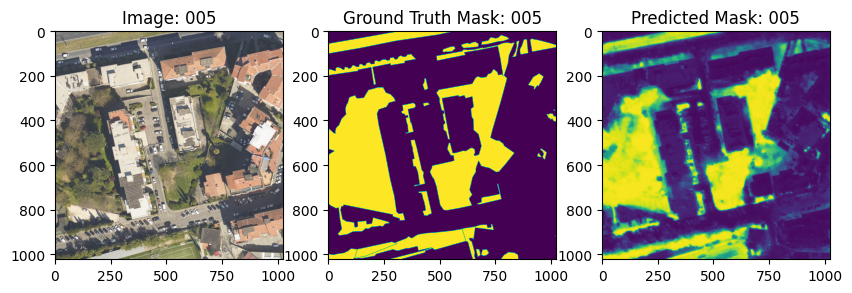

352/352 [==============================] - 116s 331ms/step - loss: 0.2140 - binary_accuracy: 0.9519 - val_loss: 0.2296 - val_binary_accuracy: 0.9228 - lr: 0.0010
Epoch 7/30
352/352 [==============================] - 116s 328ms/step - loss: 0.2006 - binary_accuracy: 0.9533 - val_loss: 0.2903 - val_binary_accuracy: 0.8838 - lr: 0.0010
Epoch 8/30
352/352 [==============================] - 115s 328ms/step - loss: 0.1846 - binary_accuracy: 0.9551 - val_loss: 0.2166 - val_binary_accuracy: 0.9265 - lr: 0.0010
Epoch 9/30
352/352 [==============================] - 116s 328ms/step - loss: 0.1804 - binary_accuracy: 0.9568 - val_loss: 0.2060 - val_binary_accuracy: 0.9208 - lr: 0.0010
Epoch 10/30
352/352 [==============================] - 116s 329ms/step - loss: 0.1626 - binary_accuracy: 0.9584 - val_loss: 0.2006 - val_binary_accuracy: 0.9348 - lr: 0.0010
Epoch 11/30
1/1 [==============================] - 0s 26ms/step


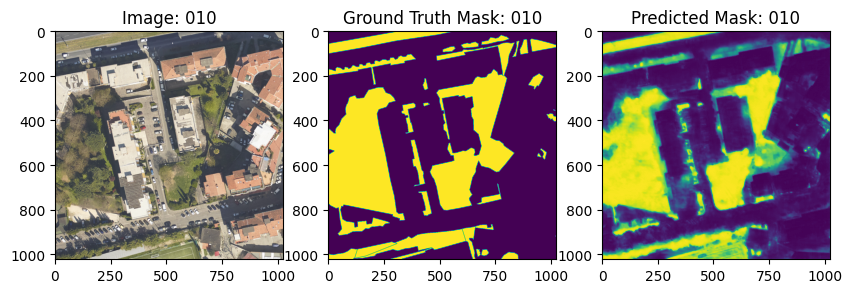

352/352 [==============================] - 116s 331ms/step - loss: 0.1707 - binary_accuracy: 0.9575 - val_loss: 0.1664 - val_binary_accuracy: 0.9441 - lr: 0.0010
Epoch 12/30
352/352 [==============================] - 116s 328ms/step - loss: 0.1535 - binary_accuracy: 0.9599 - val_loss: 0.1648 - val_binary_accuracy: 0.9390 - lr: 0.0010
Epoch 13/30
352/352 [==============================] - 116s 328ms/step - loss: 0.1424 - binary_accuracy: 0.9615 - val_loss: 0.1719 - val_binary_accuracy: 0.9341 - lr: 0.0010
Epoch 14/30
352/352 [==============================] - 116s 328ms/step - loss: 0.1488 - binary_accuracy: 0.9602 - val_loss: 0.1744 - val_binary_accuracy: 0.9332 - lr: 0.0010
Epoch 15/30
352/352 [==============================] - 115s 328ms/step - loss: 0.1409 - binary_accuracy: 0.9599 - val_loss: 0.2563 - val_binary_accuracy: 0.9151 - lr: 0.0010
Epoch 16/30
1/1 [==============================] - 0s 25ms/step


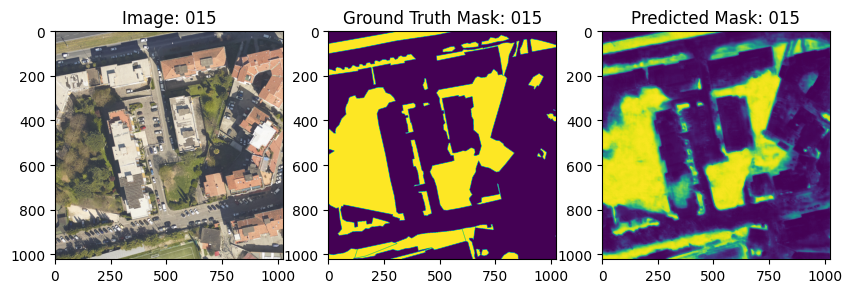

352/352 [==============================] - 116s 331ms/step - loss: 0.1367 - binary_accuracy: 0.9605 - val_loss: 0.1648 - val_binary_accuracy: 0.9447 - lr: 0.0010
Epoch 17/30
352/352 [==============================] - 116s 329ms/step - loss: 0.1311 - binary_accuracy: 0.9650 - val_loss: 0.1374 - val_binary_accuracy: 0.9498 - lr: 1.0000e-04
Epoch 18/30
352/352 [==============================] - 116s 329ms/step - loss: 0.1159 - binary_accuracy: 0.9658 - val_loss: 0.1311 - val_binary_accuracy: 0.9517 - lr: 1.0000e-04
Epoch 19/30
352/352 [==============================] - 116s 328ms/step - loss: 0.1270 - binary_accuracy: 0.9655 - val_loss: 0.1351 - val_binary_accuracy: 0.9509 - lr: 1.0000e-04
Epoch 20/30
352/352 [==============================] - 116s 329ms/step - loss: 0.1216 - binary_accuracy: 0.9661 - val_loss: 0.1310 - val_binary_accuracy: 0.9523 - lr: 1.0000e-04
Epoch 21/30
1/1 [==============================] - 0s 25ms/step


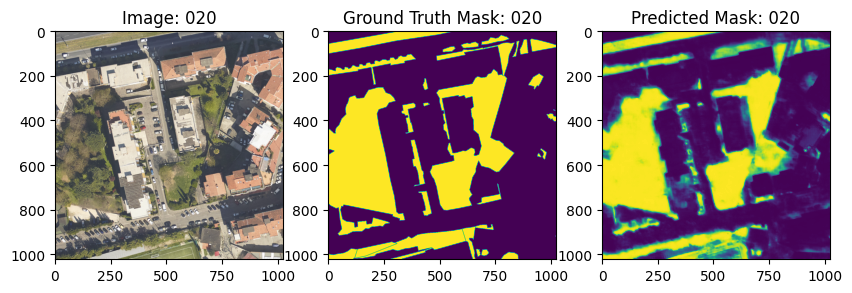

352/352 [==============================] - 116s 330ms/step - loss: 0.1168 - binary_accuracy: 0.9664 - val_loss: 0.1321 - val_binary_accuracy: 0.9516 - lr: 1.0000e-04
Epoch 22/30
352/352 [==============================] - 116s 328ms/step - loss: 0.1137 - binary_accuracy: 0.9668 - val_loss: 0.1280 - val_binary_accuracy: 0.9520 - lr: 1.0000e-05
Epoch 23/30
352/352 [==============================] - 116s 328ms/step - loss: 0.1146 - binary_accuracy: 0.9669 - val_loss: 0.1293 - val_binary_accuracy: 0.9521 - lr: 1.0000e-05
Epoch 24/30
352/352 [==============================] - 116s 328ms/step - loss: 0.1168 - binary_accuracy: 0.9666 - val_loss: 0.1286 - val_binary_accuracy: 0.9523 - lr: 1.0000e-05
Epoch 25/30
352/352 [==============================] - 116s 328ms/step - loss: 0.1185 - binary_accuracy: 0.9669 - val_loss: 0.1301 - val_binary_accuracy: 0.9521 - lr: 1.0000e-06
Epoch 26/30
1/1 [==============================] - 0s 25ms/step


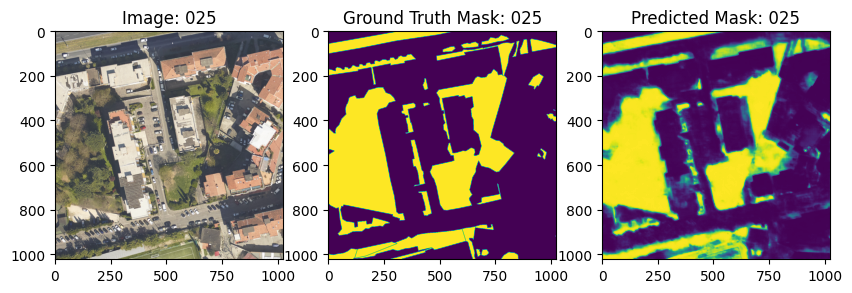

352/352 [==============================] - 116s 331ms/step - loss: 0.1137 - binary_accuracy: 0.9670 - val_loss: 0.1286 - val_binary_accuracy: 0.9522 - lr: 1.0000e-06
Epoch 27/30
352/352 [==============================] - 116s 328ms/step - loss: 0.1176 - binary_accuracy: 0.9670 - val_loss: 0.1289 - val_binary_accuracy: 0.9522 - lr: 1.0000e-06
Epoch 28/30
352/352 [==============================] - 116s 328ms/step - loss: 0.1204 - binary_accuracy: 0.9667 - val_loss: 0.1308 - val_binary_accuracy: 0.9520 - lr: 1.0000e-07
Epoch 29/30
352/352 [==============================] - 116s 328ms/step - loss: 0.1200 - binary_accuracy: 0.9669 - val_loss: 0.1293 - val_binary_accuracy: 0.9521 - lr: 1.0000e-07
Epoch 30/30
352/352 [==============================] - 116s 328ms/step - loss: 0.1178 - binary_accuracy: 0.9666 - val_loss: 0.1296 - val_binary_accuracy: 0.9521 - lr: 1.0000e-07


In [16]:
# System RAM : ~25GB
# GPU RAM : ~35GB

hist = att_unet.fit(train_cropped_images, train_cropped_masks, batch_size=4,
                epochs=30, callbacks=callbacks,
                validation_data=(val_cropped_images,val_cropped_masks))

Best validation score: $0.9523$, epoch $20$.
Associated training score: $0.9661$.

Better than UNET!

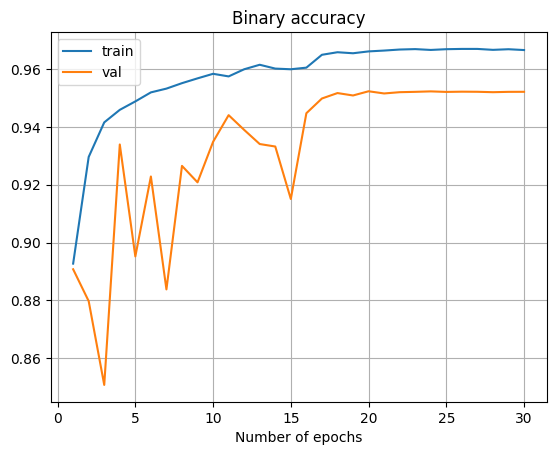

In [18]:
from utils.evaluation import plot_history
plot_history(hist)

### Load best model

In [20]:
att_unet.load_weights(os.path.join('weights', 'ATT_UNET.20-0.9523 RGB.hdf5'))

### Visualize the predictions on a validation crop

(1024, 1024, 3)
1/1 [==============================] - 0s 35ms/step


<Figure size 640x480 with 0 Axes>

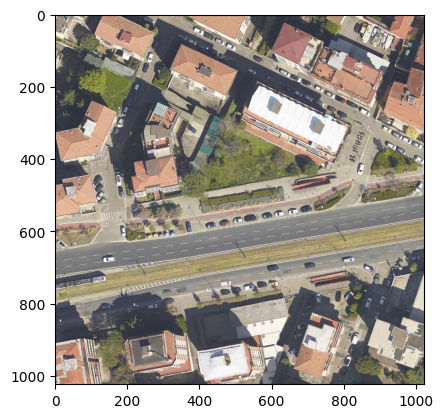

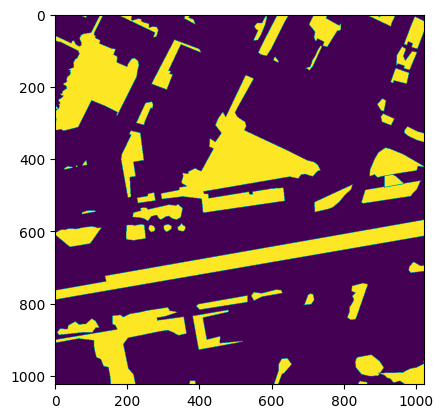

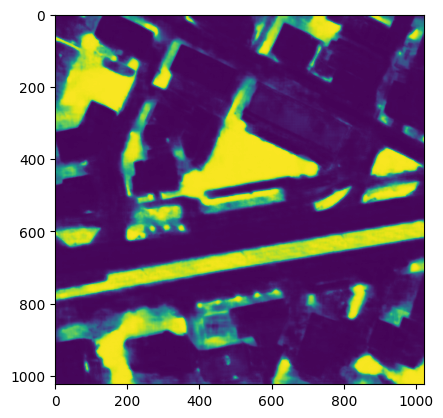

<Figure size 640x480 with 0 Axes>

In [21]:
# Visualize the predicted scores on a validation crop

index = 12
img = val_cropped_images[index, :, :, :]
mask = val_cropped_masks[index, :, :, 0]

plt.imshow(img)
plt.figure()

plt.imshow(mask, vmin=0, vmax=1)
plt.figure()

print(img.shape)
img = np.expand_dims(img, axis=0)
pred = att_unet.predict(img)
binary_preds = np.argmax(pred, axis=-1).astype('uint8')
binary_preds = binary_preds[0, :]
#binary_mask = Image.fromarray(binary_preds)
#plt.imshow(binary_preds[..., 0])#cmap='gray', vmin=0, vmax=1)
plt.imshow(pred[0, :, :, 0], vmin=0, vmax=1)
plt.figure()

### Validation crops evaluation
Evaluation on the validation crops.

In [22]:
from utils.evaluation import compute_pixelwise_retrieval_metrics

val_cropped_preds = att_unet.predict(val_cropped_images, batch_size=4)
compute_pixelwise_retrieval_metrics(val_cropped_preds[..., 0], val_cropped_masks[..., 0])

88/88 [==============================] - 5s 52ms/step


{'auroc': 0.9901063734681932,
 'fpr': array([0.        , 0.        , 0.        , ..., 0.99999993, 0.99999996,
        1.        ]),
 'tpr': array([0.0000000e+00, 1.3723128e-08, 5.4892512e-08, ..., 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00]),
 'optimal_threshold': 0.47983885,
 'optimal_fpr': 0.023324440826069225,
 'optimal_fnr': 0.024428988044912166}

Auroc: $0.9901$. Optimal threshold: $0.48$.

Better than UNET!

### Validation full image evaluation
Evaluation on the full validation image. First on the binary predictions, and then on the polylines mask.


**1) Binary predictions**

In [ ]:
from utils.utils import predict_on_img

val_img = val_images[0]
val_mask = val_masks[0]

# Predictions on the full validation image.
# (Basically, aggregation of the predictions on the crops).
val_preds = predict_on_img(att_unet, val_img, step=step, batch_size=4,
                           crop_size=crop_size, use_gaussian=False);

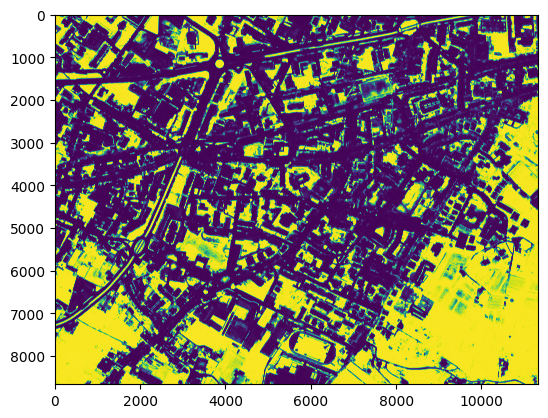

In [24]:
plt.imshow(val_preds)

In [25]:
# Compute the binary accuracy
acc = tf.keras.metrics.BinaryAccuracy()
acc.update_state(val_mask, val_preds)
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.95260566>

Binary accuracy: $0.9526$.

In [26]:
# With best threshold
threshold = 0.45
acc = tf.keras.metrics.BinaryAccuracy(threshold=0.48)
acc.update_state(val_mask, val_preds)
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.95253503>

Binary accuracy: $0.9525$.

In [28]:
compute_pixelwise_retrieval_metrics(val_preds[..., 0], val_mask[..., 0])

{'auroc': 0.9903610788862347,
 'fpr': array([0.        , 0.        , 0.        , ..., 0.99999993, 0.99999997,
        1.        ]),
 'tpr': array([0.00000000e+00, 2.29810092e-07, 7.66033639e-07, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 'optimal_threshold': 0.478,
 'optimal_fpr': 0.02311442727368198,
 'optimal_fnr': 0.024366273055355946}

Auroc: $0.99$. Best threshold: $0.478$.

Better than UNET!

**2) Polylines mask**

In [29]:
from PIL import ImageDraw
from utils.utils import get_polylines

# Thresholded binary predictions: either 0 or 1
binary_preds = (val_preds>threshold).astype('uint8')

# Compute the poly-lines
tolerance = 1.
min_area = 10
poly_lines = get_polylines(binary_preds, tolerance=tolerance, min_area=min_area)

# Compute the polylines mask
polyline_mask = np.zeros(shape=binary_preds.shape[:2], dtype=np.uint8)
polyline_mask = Image.fromarray(polyline_mask)
draw_polyline = ImageDraw.Draw(polyline_mask)
for p in poly_lines:
    draw_polyline.polygon(p, fill=1)
#polyline_mask.putpalette(get_palette())
#polyline_mask.save(join(out_folder, f"{img_basename}_polylines.png"))
polyline_mask = np.array(polyline_mask)

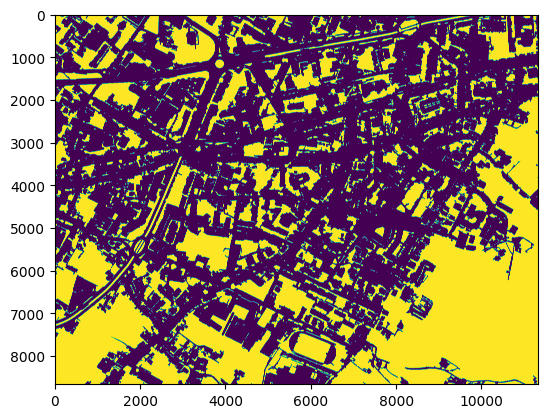

In [30]:
plt.imshow(polyline_mask)

In [31]:
# Compute the binary accuracy
acc = tf.keras.metrics.BinaryAccuracy()
acc.update_state(val_mask, polyline_mask)
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9434875>

Binary accuracy: $0.9435$. Better than UNET!

*We remind that the vectorization process makes the mask better looking and more regular. The price to pay is some points of the accuracy...*

In [32]:
compute_pixelwise_retrieval_metrics(polyline_mask, val_mask[..., 0])

{'auroc': 0.9441859936298909,
 'fpr': array([0.        , 0.05926364, 1.        ]),
 'tpr': array([0.        , 0.94763563, 1.        ]),
 'optimal_threshold': 1,
 'optimal_fpr': 0.03563176506182385,
 'optimal_fnr': 0.020880733876949057}

Auroc: $0.944$.

### Save the polylines mask

In [ ]:
# Save polylines mask
from utils.utils import get_palette
m = Image.fromarray(polyline_mask)
m.putpalette(get_palette())
m.save("polylines.png")